## Takeaway name classifier deep learning live demo


In [133]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [134]:
from fastai import *
from fastai.text import *
import string
from unidecode import unidecode


## Build a Fastai Data Loader

Load in the dataframe and extract indexes for training, validation and balanced trainings.

In [135]:
df = pd.read_csv('09_01_2020_use_name_no_burg.csv')

valid_idx = df[df.valid].index
train_idx = df[~df.valid].index

bal_idx = []
for k, v in zip(df.index, df.bal):
    bal_idx += [k]*v



In [136]:
class LetterTokenizer(BaseTokenizer):
    "Character level tokenizer function."
    def __init__(self, lang): pass
    def tokenizer(self, t:str) -> List[str]:
        out = []
        i = 0
        while i < len(t):
            if t[i:].startswith(BOS):
                out.append(BOS)
                i += len(BOS)
            else:
                out.append(t[i])
                i += 1
        return out
            
    def add_special_cases(self, toks:Collection[str]): pass

In [137]:
itos = [UNK, BOS] + list(string.ascii_lowercase + " -'@&)(." +"0123456789")

In [138]:
vocab=Vocab(itos)
tokenizer=Tokenizer(LetterTokenizer, pre_rules=[], post_rules=[])

In [139]:
train_df = df.iloc[train_idx, [3,2]]
bal_df = df.iloc[bal_idx, [3,2]]
valid_df = df.iloc[valid_idx, [3,2]]

## Classifier with Just Eat data

In [140]:
data = TextClasDataBunch.from_df(path='.', train_df=bal_df, valid_df=valid_df,
                         tokenizer=tokenizer, vocab=vocab,
                         mark_fields=False, bs=128)

In [141]:
learn = text_classifier_learner(data, AWD_LSTM, drop_mult=0.4, bptt=70)


In [142]:
learn.load('2020_01_13_sep_ff_no_burg')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (45000 items)
x: TextList
xxbos   s o u t h e r n   f r i e d   c h i c k e n     a n d     p i z z a,xxbos   m a h a r a n i   i n d i a n   c u i s i n e,xxbos   s w e e t   j a m r o c k,xxbos   s w e e t   j a m r o c k,xxbos   z a a f r a n
y: CategoryList
Fast Food,Indian,Fast Food,Fast Food,Indian
Path: .;

Valid: LabelList (3600 items)
x: TextList
xxbos   j     a n d     d   k e b a b,xxbos   v a r i e t y s   t a k e a w a y,xxbos   h o t   e x p r e s s,xxbos   f a m i l y   k e b a b     a n d     p i z z a r i a,xxbos   s u r f     a n d     t u r f
y: CategoryList
Kebab,Fast Food,Kebab,Fast Food,Fast Food
Path: .;

Test: None, model=SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(46, 400, padding_idx=1)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(46, 400, padding_idx=1)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400

In [143]:
learn.predict("mcdonalds")

(Category Fast Food,
 tensor(3),
 tensor([4.0344e-08, 7.3163e-04, 4.8839e-03, 6.3059e-01, 6.6302e-02, 6.6771e-02,
         4.2613e-03, 2.2640e-01, 6.2313e-05]))

In [155]:
learn.predict("codfather")

(Category Fish & Chips,
 tensor(4),
 tensor([2.0455e-10, 2.2911e-05, 3.1585e-08, 9.8026e-04, 9.9860e-01, 1.8116e-05,
         3.7028e-06, 3.6944e-04, 1.1693e-06]))

In [154]:
learn.predict("sapna")

(Category Indian,
 tensor(5),
 tensor([4.1237e-06, 1.3438e-02, 1.7726e-03, 1.1815e-01, 1.6704e-02, 7.5678e-01,
         2.6985e-02, 6.2025e-02, 4.1321e-03]))

In [153]:
learn.predict("fire and dough")

(Category Pizza,
 tensor(7),
 tensor([6.9797e-04, 2.7426e-04, 3.8446e-02, 4.2568e-02, 1.9213e-04, 4.2688e-03,
         4.3150e-05, 9.1344e-01, 7.1125e-05]))

In [152]:
learn.predict("top chef")

(Category Chinese,
 tensor(1),
 tensor([1.1111e-05, 8.9174e-01, 3.7636e-04, 5.8162e-02, 1.7386e-03, 1.7690e-02,
         9.1996e-05, 2.8737e-02, 1.4502e-03]))

In [151]:
learn.predict("papa johns")

(Category Sand/Caf/Bake,
 tensor(8),
 tensor([9.7993e-06, 8.7131e-04, 1.8401e-05, 1.1170e-01, 8.5396e-02, 1.0023e-01,
         6.1561e-04, 3.6917e-02, 6.6424e-01]))

In [150]:
learn.predict("gormans")

(Category Fish & Chips,
 tensor(4),
 tensor([2.7999e-04, 9.8991e-04, 1.1979e-05, 2.9671e-01, 6.6032e-01, 7.5562e-03,
         1.9806e-03, 3.0937e-02, 1.2160e-03]))

In [149]:
learn.predict("cocum")

(Category Indian,
 tensor(5),
 tensor([1.3060e-04, 2.7245e-02, 8.0203e-04, 3.5946e-01, 8.6047e-04, 5.4965e-01,
         1.4174e-03, 1.4942e-02, 4.5484e-02]))

In [148]:
learn.predict("jolly fryer")

(Category Fish & Chips,
 tensor(4),
 tensor([3.1732e-14, 1.3275e-05, 2.9193e-09, 7.2418e-06, 9.9988e-01, 9.9514e-05,
         3.3052e-10, 4.1249e-06, 7.8701e-09]))

In [147]:
learn.predict("maldon king kebab and pizza")

(Category Fast Food,
 tensor(3),
 tensor([3.0722e-10, 7.9606e-06, 2.5238e-08, 9.9997e-01, 3.0779e-09, 4.0581e-06,
         1.3736e-06, 1.4418e-05, 4.1177e-08]))

In [144]:
learn.predict("al-jafal cafe")


(Category Sand/Caf/Bake,
 tensor(8),
 tensor([1.6013e-05, 3.9977e-04, 2.5753e-04, 8.1630e-03, 3.2533e-03, 2.0145e-01,
         9.1516e-03, 3.7111e-01, 4.0619e-01]))

In [165]:
learn.predict("azka turkish")

(Category Kebab,
 tensor(6),
 tensor([7.4510e-05, 6.8749e-05, 3.5376e-04, 1.1844e-01, 3.0040e-05, 4.8895e-02,
         8.1287e-01, 1.9241e-02, 2.9484e-05]))

In [187]:
learn.predict("yefsis")

(Category Kebab,
 tensor(6),
 tensor([4.3993e-05, 8.5547e-02, 1.0907e-04, 3.7502e-02, 4.5534e-03, 3.3907e-02,
         8.3505e-01, 2.8743e-03, 4.1815e-04]))

In [168]:
    def confusion_matrix(self):
        "Confusion matrix as an `np.ndarray`"
        x=torch.arange(0,data.c)
        cm = ((self.pred_class==x[:,None]) & (self.y_true==x[:,None,None])).sum(2)
        return cm.cpu().numpy()

    def plot_confusion_matrix(self, normalize:bool=False, title:str='Confusion matrix', cmap:Any="Blues", figsize:tuple=None):
        "Plot the confusion matrix"
        # This function is copied from the scikit docs
        cm = self.confusion_matrix()
        plt.figure(figsize=figsize)
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, self.data.classes, rotation=45)
        plt.yticks(tick_marks, self.data.classes)

        if normalize: cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

In [21]:
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)

In [145]:
#txt_ci = TextClassificationInterpretation.from_learner(learn)
interp2 = TextClassificationInterpretation(learn, *learn.get_preds(with_loss=True, ordered=True))

In [146]:
#txt_ci.show_top_losses(20)
blah = interp2.show_top_losses(10000)


Text,Prediction,Actual,Loss,Probability
xxbos k h a o g a e n g t h a i,Chinese,Chicken,24.79,0.00
xxbos s w e e t s ' n ' t r e a t s,Desserts,Sand/Caf/Bake,22.43,0.00
xxbos k h a n ' s k a r a h i,Indian,Kebab,20.01,0.00
xxbos p u n j a b i c o n n e c t i o n,Indian,Fish & Chips,18.53,0.00
xxbos d e l i e s p r e s s o,Sand/Caf/Bake,Chicken,18.40,0.00
xxbos j a m e s f a s t f o o d,Fast Food,Desserts,18.02,0.00
xxbos b a b a y a n i,Indian,Chicken,17.77,0.00
xxbos s u n f l o w e r s,Chinese,Sand/Caf/Bake,17.42,0.00
xxbos z a p a t i s t a b u r r i t o b a r n e w c a s t l e,Pizza,Chicken,17.21,0.00
xxbos c o o p e r t h a i r e s t a u r a n t,Chinese,Sand/Caf/Bake,16.81,0.00


In [166]:
my_top_losses = interp2.top_losses()
my_ds = interp2.data.dl('Valid').dataset
my_classes = interp2.data.valid_ds.classes
my_preds_class = interp2.pred_class
tl_val,tl_idx = my_top_losses


items = []
for idx in tl_idx:
    tx,cl = interp2.data.valid_ds[idx]
    cl = cl.data
    txt =  ' '.join([''.join(i.split()) for i in re.split(r' {2,}',tx.text)])[6:]
    tmp = [txt, f'{my_classes[my_preds_class[idx]]}', f'{my_classes[cl]}']
    items.append(tmp)
items = np.array(items)
names = ['Text', 'Prediction', 'Actual']
df = pd.DataFrame({n:items[:,i] for i,n in enumerate(names)}, columns=names)

In [167]:
df.to_csv('13_01_2020_errors.csv', index=False)

In [175]:
cm = interp2.confusion_matrix()

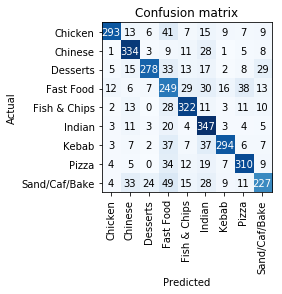

In [182]:
interp2.plot_confusion_matrix()

In [179]:
#Precision = tp / tp + fp
recall = np.diag(cm) / np.sum(cm, axis = 1)
precision = np.diag(cm) / np.sum(cm, axis = 0)

In [180]:
recall

array([0.7325, 0.835 , 0.695 , 0.6225, 0.805 , 0.8675, 0.735 , 0.775 , 0.5675])

In [181]:
precision

array([0.896024, 0.764302, 0.860681, 0.498   , 0.766667, 0.652256, 0.854651, 0.775   , 0.716088])